## 1. Data Loading and Basic Checks

In this section, we import the necessary Python libraries and load the dataset.  
We then perform some initial checks to make sure the file is read correctly:  

- Verify the current working directory and available files.  
- Load the dataset into a pandas DataFrame.  
- Preview the first 5 rows to understand the structure.  
- Check data types of each column.  
- Identify missing values for a first impression of data quality.  


In [1]:
# =============================================================================
# 0️⃣ Import Libraries
# =============================================================================
# pandas: for data manipulation and analysis
# numpy: for numerical operations
# matplotlib & seaborn: for data visualization
# os: to check current working directory and files
# sklearn & imblearn: for preprocessing, modeling, and resampling

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from imblearn.over_sampling import SMOTE
from collections import Counter

# =============================================================================
# 1️⃣ Load Dataset
# =============================================================================
# Load the CSV directly from GitHub (no need for local file).




# First, try to read with header
df = pd.read_csv("Output.csv", sep=";")


# If the columns look like numbers only, it probably means no header → reload without header
if all(str(col).isdigit() for col in df.columns):
    df = pd.read_csv(url, sep=";", header=None)

# =============================================================================
# 2️⃣ Basic Checks
# =============================================================================
import os

print("Dataset shape:", df.shape)
print("Column names (first 10):", df.columns.tolist()[:10])  # show first 10 column names
print("\n--- First 5 Rows ---")
print(df.head())

print("\n--- Data Info ---")
print(df.info())

print("\n--- Missing Values per Column ---")
print(df.isnull().sum())



Dataset shape: (6824, 46)
Column names (first 10): ['player', 'age', 'height', 'nationality', 'position', 'value', 'games', 'minutes', 'goals', 'assists']

--- First 5 Rows ---
                 player  age  height nationality  position     value  games  \
0        Zouhair Feddal   30   192.0     Morocco  Defender   4000000     17   
1    Zlatan Ibrahimović   37   195.0      Sweden   Forward   3500000     18   
2       Zinedine Ferhat   26   180.0     Algeria   Forward   2000000     26   
3  Zinédine Ould Khaled   19   195.0      France  Midfield     15000      1   
4            Zeki Celik   22   180.0      Turkey  Defender  20000000     23   

   minutes  goals  assists  ...  LgRk  MP   W   D   L  GF  GA  Pts  CL  WinCL  
0     1431      1        2  ...    15  38  10  11  17  48  60   41  No     No  
1     1362     10        5  ...     6  38  19   9  10  63  46   66  No     No  
2     2246      3        4  ...    18  28   7   6  15  29  44   27  No     No  
3       59      0        0  

## 2. Exploratory Data Analysis (EDA)


We explored the dataset to better understand its structure, relationships, and data quality:

- **Target variable (`goal_category`)**: Created by categorizing goals into Low (≤2), Medium (3–7), and High (>7).  (These thresholds were chosen based on football domain knowledge (forwards typically score >7, midfielders around 3–7, defenders and goalkeepers ≤2) and the distribution of the data.)
  The distribution is highly imbalanced (Low: 5316, Medium: 1087, High: 421).  
- **Numeric features**: Summary statistics show realistic ranges (e.g., average age ≈ 25, height ≈ 182 cm).  
  Goal-related features such as goals, assists, and value are strongly right-skewed, which is expected in football data.  
- **Categorical features**:  
  - *Position* is strongly related to `goal_category` (Forwards dominate High/Medium, Defenders and Goalkeepers dominate Low).  
  - *Nationality* and *squad* distributions confirm a wide variety of players across leagues.  
- **Missing values**: Only one missing entry in `height` (filled with mean).  
  `CLBestScorer` had many NaNs; instead, we created a binary feature `played_CL` (suggested by Samaneh).  
- **Champions League participation (`played_CL`)**:  
  Almost all High scorers played CL (400/421), while Low scorers include both CL and non-CL players.  
  This indicates CL participation can be a useful predictor of goal-scoring category.

These insights highlight strong relationships (e.g., position and CL participation with goal_category) and confirm that preprocessing must address class imbalance before modeling.




--- Target variable preview (goals vs goal_category) ---
   goals goal_category
0      1           Low
1     10          High
2      3        Medium
3      0           Low
4      0           Low
5      0           Low
6      0           Low
7      0           Low
8      1           Low
9      8          High

--- Summary statistics for numeric columns ---
               age       height         value        games      minutes  \
count  6824.000000  6823.000000  6.824000e+03  6824.000000  6824.000000   
mean     25.429513   181.963506  1.023350e+07    19.031653  1342.866208   
std       4.444391     9.529490  1.660910e+07    11.175267   972.311088   
min       0.000000     0.000000  5.000000e+01     1.000000     1.000000   
25%      22.000000   178.000000  1.500000e+06     9.000000   455.000000   
50%      25.000000   183.000000  4.000000e+06    20.000000  1236.000000   
75%      28.000000   187.000000  1.200000e+07    29.000000  2121.000000   
max      41.000000   203.000000  2.000000

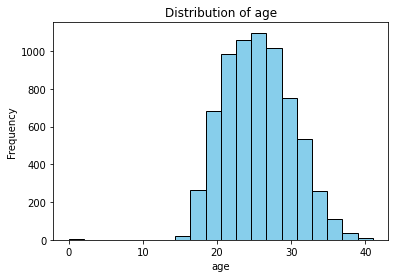

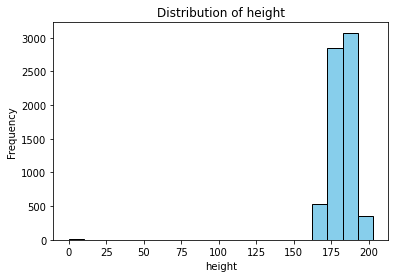

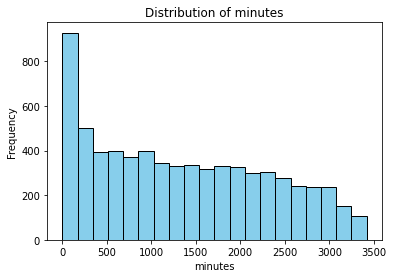

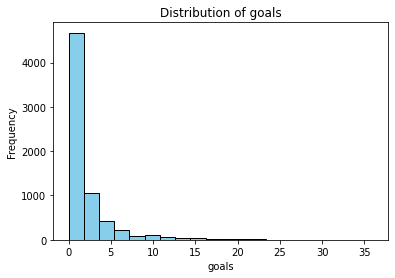

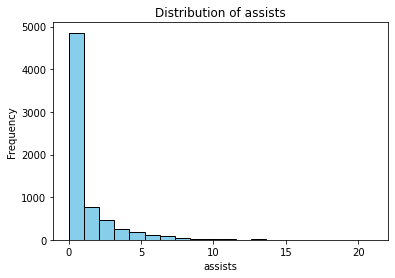

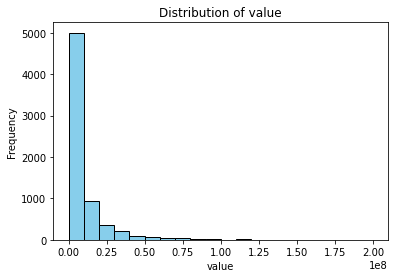

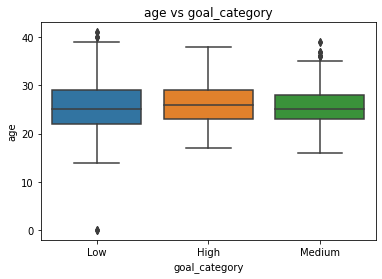

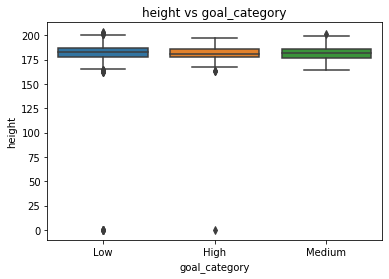

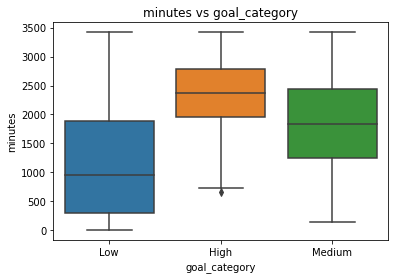

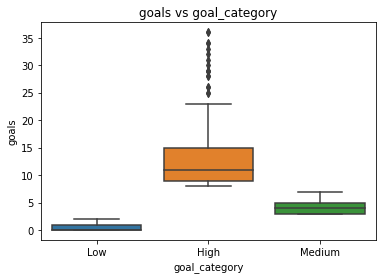

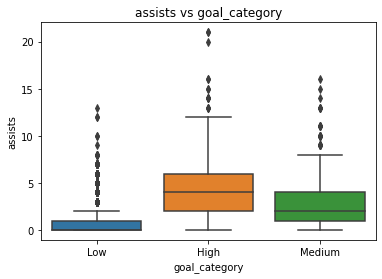

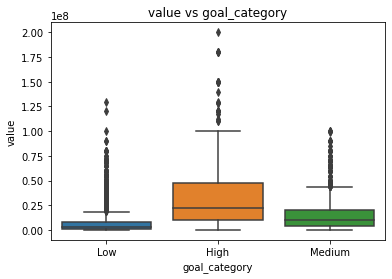


--- Frequencies of categorical columns ---

Frequency counts for nationality:
Spain             1044
France             930
Italy              780
United Kingdom     639
Germany            578
Brazil             305
Argentina          242
Portugal           154
Netherlands        148
Belgium            132
Name: nationality, dtype: int64

Frequency counts for position:
Defender      2415
Midfield      2181
Forward       1699
Goalkeeper     529
Name: position, dtype: int64

Frequency counts for squad:
Monaco           92
Genoa            86
Cagliari         84
Paris S-G        82
Sassuolo         82
SPAL             81
Real Sociedad    79
Bologna          78
Watford          78
Villarreal       78
Name: squad, dtype: int64

Frequency counts for Season:
01/01/2019    2581
01/01/2017    2186
01/01/2018    2057
Name: Season, dtype: int64

Frequency counts for league:
Serie A           1513
La Liga           1463
Premier League    1376
Ligue 1           1330
Bundesliga        1142
Name: le

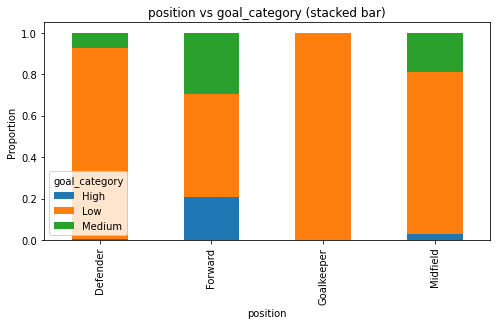


nationality vs goal_category (cross-tab):
goal_category  High  Low  Medium
nationality                     
Albania           0   24       0
Algeria           6   46      11
Angola            0    3       1
Argentina        31  162      49
Armenia           1    3       2


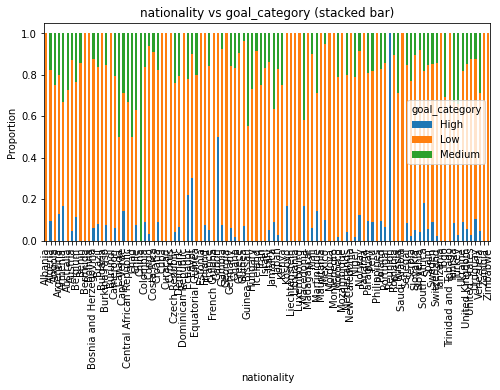


squad vs goal_category (cross-tab):
goal_category  High  Low  Medium
squad                           
Alavés            4   57       8
Amiens            2   61       7
Angers            2   52      11
Arsenal           6   53      15
Aston Villa       1   19       5


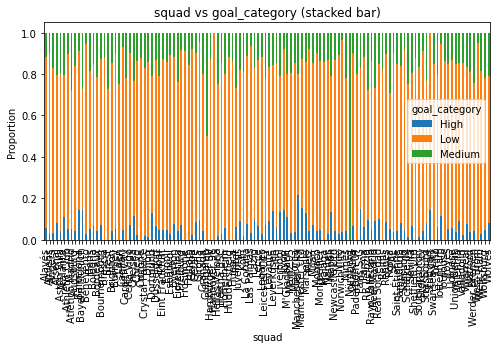


--- Missing values per column ---
player                       0
age                          0
height                       1
nationality                  0
position                     0
value                        0
games                        0
minutes                      0
goals                        0
assists                      0
crosses                      0
tackles                      0
pressures                    0
blocks                       0
touches                      0
fouls                        0
fouled                       0
offsides                     0
own goals                    0
ball recoveries              0
saves                        0
squad                        0
Season                       0
league                       0
Attendance                   0
games starts                 0
passes completed             0
sca                          0
gca                          0
dribbles completed           0
pens won                     0
goal

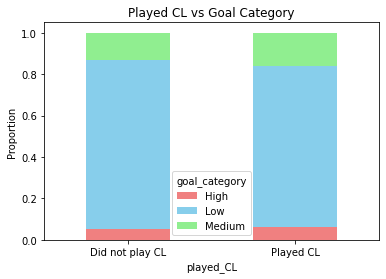

In [2]:
# -------------------------------
# 0️⃣ Create Target Variable (goal_category)
# -------------------------------
# Categorize players based on goals scored
def categorize_goals(goals):
    if goals <= 2:
        return 'Low'
    elif goals <= 7:
        return 'Medium'
    else:
        return 'High'

df['goal_category'] = df['goals'].apply(categorize_goals)

print("\n--- Target variable preview (goals vs goal_category) ---")
print(df[['goals', 'goal_category']].head(10))


# -------------------------------
# 1️⃣ Summary statistics for numeric columns
# -------------------------------
# Generate descriptive statistics (mean, std, min, max, quartiles)
# for all numeric columns to understand ranges and distributions.
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
print("\n--- Summary statistics for numeric columns ---")
print(df[numeric_cols].describe())


# -------------------------------
# 2️⃣ Distribution of selected numeric features
# -------------------------------
# Plot histograms only for the most relevant numeric features
# instead of all numeric columns (to avoid clutter).
important_numeric = ['age', 'height', 'minutes', 'goals', 'assists', 'value']

for col in important_numeric:
    plt.figure(figsize=(6,4))
    plt.hist(df[col].dropna(), bins=20, color='skyblue', edgecolor='black')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()


# -------------------------------
# 3️⃣ Relationship of numeric features with target (goal_category)
# -------------------------------
# Use boxplots to see how numeric features vary across the target categories.
for col in important_numeric:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='goal_category', y=col, data=df)
    plt.title(f"{col} vs goal_category")
    plt.show()


# -------------------------------
# 4️⃣ Frequency of categorical features
# -------------------------------
# Show the distribution of values for categorical columns.
categorical_cols = df.select_dtypes(include=['object']).columns

print("\n--- Frequencies of categorical columns ---")
for col in categorical_cols:
    if col != 'player':   # exclude 'player' since it is only an identifier
        print(f"\nFrequency counts for {col}:")
        print(df[col].value_counts().head(10))  # show only top 10 values


# -------------------------------
# 5️⃣ Relationship of categorical features with target
# -------------------------------
# Cross-tab and stacked bar plots for selected categorical variables
# to see their relationship with the target.
for col in ['position', 'nationality', 'squad']:
    ct = pd.crosstab(df[col], df['goal_category'])
    print(f"\n{col} vs goal_category (cross-tab):")
    print(ct.head())  

    # Normalized stacked bar plot
    ct_norm = ct.div(ct.sum(axis=1), axis=0)
    ct_norm.plot(kind='bar', stacked=True, figsize=(8,4))
    plt.title(f"{col} vs goal_category (stacked bar)")
    plt.ylabel("Proportion")
    plt.show()


# -------------------------------
# 6️⃣ Missing values check & handling
# -------------------------------
# Check missing values again and handle them where necessary.
print("\n--- Missing values per column ---")
print(df.isnull().sum())

# Example: fill missing value in 'height' with mean (only one missing entry).
if df['height'].isnull().sum() > 0:
    mean_height = df['height'].mean()
    df['height'] = df['height'].fillna(mean_height)
    print(f"Missing value in 'height' column filled with mean: {mean_height:.2f}")


# -------------------------------
# 7️⃣ Create binary column for Champions League participation
# -------------------------------
# The original 'CLBestScorer' column has many NaNs (most players never played CL).
# Instead of imputing, we create a binary indicator 'played_CL':
# 1 = played in CL, 0 = did not play in CL.
# (Suggested by Samaneh to indicate CL participation)

df['played_CL'] = df['CLBestScorer'].notna().astype(int)

print("\n--- Champions League participation preview ---")
print(df[['CLBestScorer', 'played_CL']].head(10))


# -------------------------------
# 8️⃣ Relationship of played_CL with target (goal_category)
# -------------------------------
# Check whether playing in CL is associated with higher goal categories.
ct = pd.crosstab(df['played_CL'], df['goal_category'])
print("\nplayed_CL vs goal_category (cross-tab):")
print(ct)

ct_norm = ct.div(ct.sum(axis=1), axis=0)
ct_norm.plot(kind='bar', stacked=True, figsize=(6,4), color=['lightcoral','skyblue','lightgreen'])
plt.title("Played CL vs Goal Category")
plt.ylabel("Proportion")
plt.xticks([0,1], ['Did not play CL', 'Played CL'], rotation=0)
plt.show()


## 3. Data Preprocessing

To prepare the dataset for machine learning, the following steps were taken:

- **Feature/Target definition**:  
  - Target variable: `goal_category`.  
  - Dropped columns: `goals` (direct leakage), `CLBestScorer` (mostly missing), and identifiers (`player`, `squad`, `Season`, `league`).  
  - Kept `played_CL` as an additional predictor.  

- **Train/Test split**:  
  - 70% training and 30% testing.  
  - Stratified sampling was used to preserve class distribution.  
  - Before resampling, training set distribution: Low = 3720, Medium = 761, High = 295.  

- **Preprocessing pipelines**:  
  - *Numeric*: mean imputation + standard scaling.  
  - *Categorical*: most-frequent imputation + one-hot encoding.  

- **Class imbalance handling**:  
  - SMOTE (Synthetic Minority Oversampling Technique) applied only to the training set.  
  - After resampling: Low = 3720, Medium = 3720, High = 3720.  
  - The test set was kept untouched for unbiased evaluation.  

This ensures the dataset is clean, features are properly encoded, and class imbalance is addressed before modeling.



In [3]:
# -------------------------------
# 1️⃣ Define Features (X) and Target (y)
# -------------------------------
# Keep 'played_CL' as a predictor, drop direct leakage columns and identifiers.
X = df.drop(columns=['goal_category', 'goals', 'CLBestScorer', 
                     'player', 'squad', 'Season', 'league'])
y = df['goal_category']

# -------------------------------
# 2️⃣ Train-Test Split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Train class distribution (before SMOTE):", Counter(y_train))
print("Test class distribution:", Counter(y_test))

# -------------------------------
# 3️⃣ Numeric and Categorical Columns
# -------------------------------
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

# -------------------------------
# 4️⃣ Preprocessing Pipelines
# -------------------------------
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# -------------------------------
# 5️⃣ Apply Preprocessing
# -------------------------------
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# -------------------------------
# 6️⃣ Apply SMOTE (only on training set)
# -------------------------------
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_processed, y_train)

print("Train class distribution (after SMOTE):", Counter(y_train_res))


Train class distribution (before SMOTE): Counter({'Low': 3720, 'Medium': 761, 'High': 295})
Test class distribution: Counter({'Low': 1596, 'Medium': 326, 'High': 126})
Numeric columns: ['age', 'height', 'value', 'games', 'minutes', 'assists', 'crosses', 'tackles', 'pressures', 'blocks', 'touches', 'fouls', 'fouled', 'offsides', 'own goals', 'ball recoveries', 'saves', 'Attendance', 'games starts', 'passes completed', 'sca', 'gca', 'dribbles completed', 'pens won', 'goals against gk', 'shots on target against', 'cards yellow', 'shots total', 'LgRk', 'MP', 'W', 'D', 'L', 'GF', 'GA', 'Pts', 'played_CL']
Categorical columns: ['nationality', 'position', 'CL', 'WinCL']
Train class distribution (after SMOTE): Counter({'Low': 3720, 'High': 3720, 'Medium': 3720})


### 4. Model Training & Evaluation (Before Tuning)

We trained three classifiers from different algorithm families:

- **Logistic Regression**: linear and interpretable baseline.  
- **Random Forest**: ensemble tree-based model for non-linear patterns.  
- **SVM (linear kernel)**: margin-based classifier.  

Models were trained on the balanced training set (after SMOTE) and tested on the original distribution. Performance was evaluated with Accuracy, Precision, Recall, F1, plus Confusion Matrices and Classification Reports.  

**Key findings:**
- **Random Forest** achieved the best overall performance (Accuracy ≈ 0.85, F1 ≈ 0.85).  
- **Logistic Regression** performed well on the Low class but struggled with Medium and High.  
- **SVM (linear)** showed similar behavior to Logistic Regression but with slightly lower overall scores.  
- Across all models, **Medium and High classes remain harder to predict**, even after SMOTE balancing.



In [4]:
# -------------------------------
# Logistic Regression
# -------------------------------
# Simple linear baseline model (multinomial handles 3 classes)
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_res, y_train_res)   # Train on balanced training set
y_pred_logreg = log_reg.predict(X_test_processed)   # Predict on test set

print("=== Logistic Regression Results ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_logreg):.4f}")
print(f"Precision (weighted): {precision_score(y_test, y_pred_logreg, average='weighted'):.4f}")
print(f"Recall (weighted): {recall_score(y_test, y_pred_logreg, average='weighted'):.4f}")
print(f"F1 Score (weighted): {f1_score(y_test, y_pred_logreg, average='weighted'):.4f}")

cm = confusion_matrix(y_test, y_pred_logreg, labels=['Low','Medium','High'])
cm_df = pd.DataFrame(cm, index=['Actual Low','Actual Medium','Actual High'],
                     columns=['Pred Low','Pred Medium','Pred High'])
print("\nConfusion Matrix:")
print(cm_df)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_logreg, digits=4))


# -------------------------------
# Random Forest
# -------------------------------
# Ensemble tree-based model, captures non-linear patterns
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_res, y_train_res)
y_pred_rf = rf_model.predict(X_test_processed)

print("=== Random Forest Results ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision (weighted): {precision_score(y_test, y_pred_rf, average='weighted'):.4f}")
print(f"Recall (weighted): {recall_score(y_test, y_pred_rf, average='weighted'):.4f}")
print(f"F1 Score (weighted): {f1_score(y_test, y_pred_rf, average='weighted'):.4f}")

cm = confusion_matrix(y_test, y_pred_rf, labels=['Low','Medium','High'])
cm_df = pd.DataFrame(cm, index=['Actual Low','Actual Medium','Actual High'],
                     columns=['Pred Low','Pred Medium','Pred High'])
print("\nConfusion Matrix:")
print(cm_df)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, digits=4))


# -------------------------------
# Support Vector Machine (SVM)
# -------------------------------
# Margin-based classifier, here with linear kernel as baseline
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train_res, y_train_res)
y_pred_svm = svm_model.predict(X_test_processed)

print("=== SVM Results ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(f"Precision (weighted): {precision_score(y_test, y_pred_svm, average='weighted'):.4f}")
print(f"Recall (weighted): {recall_score(y_test, y_pred_svm, average='weighted'):.4f}")
print(f"F1 Score (weighted): {f1_score(y_test, y_pred_svm, average='weighted'):.4f}")

cm = confusion_matrix(y_test, y_pred_svm, labels=['Low','Medium','High'])
cm_df = pd.DataFrame(cm, index=['Actual Low','Actual Medium','Actual High'],
                     columns=['Pred Low','Pred Medium','Pred High'])
print("\nConfusion Matrix:")
print(cm_df)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm, digits=4))


=== Logistic Regression Results ===
Accuracy: 0.8198
Precision (weighted): 0.8565
Recall (weighted): 0.8198
F1 Score (weighted): 0.8334

Confusion Matrix:
               Pred Low  Pred Medium  Pred High
Actual Low         1379          209          8
Actual Medium        60          213         53
Actual High           0           39         87

Classification Report:
              precision    recall  f1-score   support

        High     0.5878    0.6905    0.6350       126
         Low     0.9583    0.8640    0.9087      1596
      Medium     0.4620    0.6534    0.5413       326

    accuracy                         0.8198      2048
   macro avg     0.6694    0.7360    0.6950      2048
weighted avg     0.8565    0.8198    0.8334      2048

=== Random Forest Results ===
Accuracy: 0.8496
Precision (weighted): 0.8614
Recall (weighted): 0.8496
F1 Score (weighted): 0.8543

Confusion Matrix:
               Pred Low  Pred Medium  Pred High
Actual Low         1456          139          1
Act

## 5. Model Performance Comparison (Before Tuning)

The performance of the three classifiers was summarized in a comparison table and visualized with bar charts. The evaluation was based on Accuracy, Precision, Recall, and F1 Score.

**Results:**
- **Random Forest** performed best overall (Accuracy ≈ 0.85, F1 ≈ 0.85), showing the strongest balance across metrics.  
- **Logistic Regression** achieved solid results (Accuracy ≈ 0.82, F1 ≈ 0.83) but struggled with the Medium and High classes.  
- **SVM (linear kernel)** produced slightly weaker results (Accuracy ≈ 0.81, F1 ≈ 0.83), close to Logistic Regression but consistently lower.  
- Precision scores were similar across models (~0.85), but Random Forest showed better Recall and F1, indicating stronger class-level balance.  

These results highlight Random Forest as the best baseline model before tuning, while Logistic Regression and SVM remain reasonable but less effective.



=== Model Comparison Table (Before Tuning) ===
                 Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.819824   0.856517  0.819824  0.833405
1        Random Forest  0.849609   0.861424  0.849609  0.854269
2                  SVM  0.811035   0.857148  0.811035  0.827392


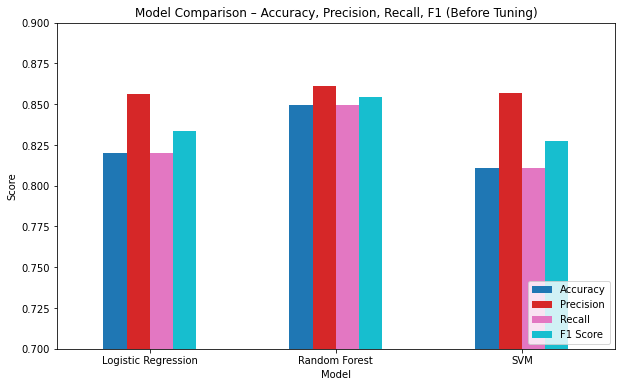

In [5]:
# -------------------------------
# Collect results for all models
# -------------------------------
results_df = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "SVM"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_logreg),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_svm)
    ],
    "Precision": [
        precision_score(y_test, y_pred_logreg, average='weighted'),
        precision_score(y_test, y_pred_rf, average='weighted'),
        precision_score(y_test, y_pred_svm, average='weighted')
    ],
    "Recall": [
        recall_score(y_test, y_pred_logreg, average='weighted'),
        recall_score(y_test, y_pred_rf, average='weighted'),
        recall_score(y_test, y_pred_svm, average='weighted')
    ],
    "F1 Score": [
        f1_score(y_test, y_pred_logreg, average='weighted'),
        f1_score(y_test, y_pred_rf, average='weighted'),
        f1_score(y_test, y_pred_svm, average='weighted')
    ]
})

print("=== Model Comparison Table (Before Tuning) ===")
print(results_df)

# -------------------------------
# Visualization of all metrics
# -------------------------------
metrics_df = results_df.set_index("Model")

metrics_df.plot(kind="bar", figsize=(10,6), colormap="tab10")
plt.title("Model Comparison – Accuracy, Precision, Recall, F1 (Before Tuning)")
plt.ylabel("Score")
plt.ylim(0.7, 0.9)   # zoom in to see differences more clearly
plt.legend(loc="lower right")
plt.xticks(rotation=0)
plt.show()


## 6. Hyperparameter Tuning – Logistic Regression

A grid search with 5-fold stratified cross-validation was performed on Logistic Regression.  
The parameter grid included different values of `C` (regularization strength), with `penalty="l2"` and `solver="lbfgs"`.  
The evaluation metric during tuning was **weighted F1**, due to the class imbalance.

**Results:**
- Best CV weighted-F1: **0.8684** with parameters `C=100, penalty=l2, solver=lbfgs, max_iter=2000`.  
- On the test set, performance was similar to the untuned model:  
  - Accuracy: **0.8145**  
  - Weighted F1: **0.8287**  
- The model remained very strong on the **Low** class, but struggled with **Medium** and **High**, where precision and recall were notably lower.  
- Compared to the baseline Logistic Regression, the tuned version showed almost no improvement, confirming that parameter tuning has limited impact for this linear model.

Overall, Logistic Regression provided a solid baseline but did not benefit significantly from hyperparameter tuning.


In [6]:
# -------------------------------
# Logistic Regression Hyperparameter Tuning
# -------------------------------

# Use stratified k-fold cross validation (5 folds) 
# to preserve class balance during tuning
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define parameter grid for Logistic Regression
# - C: regularization strength (smaller = stronger regularization)
# - penalty/solver: standard settings for multinomial logistic regression
# - max_iter: high value to ensure convergence
param_grid_lr = {
    "C": [0.01, 0.1, 1, 10, 100],
    "penalty": ["l2"],
    "solver": ["lbfgs"],
    "max_iter": [2000]
}

# Perform grid search with F1 (weighted) scoring
# Weighted F1 is used due to class imbalance
grid_lr = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=param_grid_lr,
    scoring="f1_weighted",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Fit on balanced training set (after SMOTE)
grid_lr.fit(X_train_res, y_train_res)

# Report best parameters and CV score
print("Best CV weighted-F1:", grid_lr.best_score_)
print("Best Params:", grid_lr.best_params_)

# Evaluate tuned model on test set
best_lr = grid_lr.best_estimator_
y_pred_lr_tuned = best_lr.predict(X_test_processed)

print("\n=== Logistic Regression (TUNED) – Test Results ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr_tuned):.4f}")
print(f"Precision (weighted): {precision_score(y_test, y_pred_lr_tuned, average='weighted'):.4f}")
print(f"Recall (weighted): {recall_score(y_test, y_pred_lr_tuned, average='weighted'):.4f}")
print(f"F1 (weighted): {f1_score(y_test, y_pred_lr_tuned, average='weighted'):.4f}")

# Detailed class-level performance
print("\nClassification Report (tuned LR):")
print(classification_report(y_test, y_pred_lr_tuned, digits=4))

# Confusion matrix for class-level prediction distribution
cm = confusion_matrix(y_test, y_pred_lr_tuned, labels=['Low','Medium','High'])
cm_df = pd.DataFrame(cm, index=['Actual Low','Actual Medium','Actual High'],
                     columns=['Pred Low','Pred Medium','Pred High'])
print("\nConfusion Matrix (tuned LR):")
print(cm_df)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best CV weighted-F1: 0.8684476257641218
Best Params: {'C': 100, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'lbfgs'}

=== Logistic Regression (TUNED) – Test Results ===
Accuracy: 0.8145
Precision (weighted): 0.8527
Recall (weighted): 0.8145
F1 (weighted): 0.8287

Classification Report (tuned LR):
              precision    recall  f1-score   support

        High     0.5714    0.6667    0.6154       126
         Low     0.9568    0.8609    0.9063      1596
      Medium     0.4516    0.6442    0.5310       326

    accuracy                         0.8145      2048
   macro avg     0.6600    0.7239    0.6842      2048
weighted avg     0.8527    0.8145    0.8287      2048


Confusion Matrix (tuned LR):
               Pred Low  Pred Medium  Pred High
Actual Low         1374          213          9
Actual Medium        62          210         54
Actual High           0           42         84


## 7. Hyperparameter Tuning – Random Forest

We optimize Random Forest using GridSearchCV.  

- **Parameters searched**:  
  - `n_estimators`: number of trees (100, 200, 500).  
  - `max_depth`: maximum tree depth (None, 10, 20, 30).  
  - `max_features`: number of features to consider at each split (`sqrt`, `log2`).  

- **Validation**: 5-fold Stratified Cross-Validation.  
- **Metric**: weighted F1 score.  

**Results:**
- Best CV weighted-F1: **0.9534**, with parameters `n_estimators=200, max_depth=30, max_features=sqrt`.  
- On the test set, performance was very similar to the untuned model (Accuracy ≈ 0.85, F1 ≈ 0.85).  
- Random Forest remained the best-performing classifier, showing strong results on the Low class, while Medium and High classes were still harder to predict.  

Overall, tuning confirmed the robustness of Random Forest, but gains over the baseline were limited.



In [7]:
# -------------------------------
# Random Forest Hyperparameter Tuning
# -------------------------------

# Define parameter grid:
# - n_estimators: number of trees in the forest
# - max_depth: maximum depth of each tree (None = unlimited)
# - max_features: number of features to consider at each split
param_grid_rf = {
    "n_estimators": [100, 200, 500],
    "max_depth": [None, 10, 20, 30],
    "max_features": ["sqrt", "log2"]
}

# Perform grid search with weighted F1 scoring
# 5-fold cross-validation, parallelized with all CPU cores
grid_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    scoring="f1_weighted",
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit on balanced training data (after SMOTE)
grid_rf.fit(X_train_res, y_train_res)

# Display best parameters and CV score
print("Best CV weighted-F1:", grid_rf.best_score_)
print("Best Params:", grid_rf.best_params_)

# Evaluate tuned model on test set
best_rf = grid_rf.best_estimator_
y_pred_rf_tuned = best_rf.predict(X_test_processed)

print("\n=== Random Forest (TUNED) – Test Results ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf_tuned):.4f}")
print(f"Precision (weighted): {precision_score(y_test, y_pred_rf_tuned, average='weighted'):.4f}")
print(f"Recall (weighted): {recall_score(y_test, y_pred_rf_tuned, average='weighted'):.4f}")
print(f"F1 (weighted): {f1_score(y_test, y_pred_rf_tuned, average='weighted'):.4f}")

# Detailed class-level performance
print("\nClassification Report (tuned RF):")
print(classification_report(y_test, y_pred_rf_tuned, digits=4))

# Confusion matrix to inspect misclassifications
cm = confusion_matrix(y_test, y_pred_rf_tuned, labels=['Low','Medium','High'])
cm_df = pd.DataFrame(cm, index=['Actual Low','Actual Medium','Actual High'],
                     columns=['Pred Low','Pred Medium','Pred High'])
print("\nConfusion Matrix (tuned RF):")
print(cm_df)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best CV weighted-F1: 0.953379979063963
Best Params: {'max_depth': 30, 'max_features': 'sqrt', 'n_estimators': 200}

=== Random Forest (TUNED) – Test Results ===
Accuracy: 0.8472
Precision (weighted): 0.8583
Recall (weighted): 0.8472
F1 (weighted): 0.8517

Classification Report (tuned RF):
              precision    recall  f1-score   support

        High     0.7091    0.6190    0.6610       126
         Low     0.9393    0.9117    0.9253      1596
      Medium     0.5193    0.6196    0.5650       326

    accuracy                         0.8472      2048
   macro avg     0.7226    0.7168    0.7171      2048
weighted avg     0.8583    0.8472    0.8517      2048


Confusion Matrix (tuned RF):
               Pred Low  Pred Medium  Pred High
Actual Low         1455          140          1
Actual Medium        93          202         31
Actual High           1           47         78


## 8. Hyperparameter Tuning – Support Vector Machine (SVM)

We optimize Support Vector Machine using GridSearchCV.  

- **Parameters searched**:  
  - `C`: regularization strength (0.1, 1, 10).  
  - `kernel`: type of kernel function (`linear`, `rbf`).  
  - `gamma`: kernel coefficient for `rbf` (`scale`, `auto`).  

- **Validation**: 5-fold Stratified Cross-Validation.  
- **Metric**: weighted F1 score.  

**Results:**
- Best CV weighted-F1: **0.9603**, with parameters `C=10, gamma=scale, kernel=rbf`.  
- On the test set, Accuracy ≈ **0.837** and F1 ≈ **0.842**, which is better than the baseline SVM.  
- The tuned RBF kernel outperformed the linear kernel, confirming the importance of non-linear decision boundaries.  
- However, the model still struggled on the Medium and High classes compared to the Low class.  

Overall, tuning significantly improved SVM performance, but Random Forest remained the strongest model.



In [8]:
# -------------------------------
# Support Vector Machine (SVM) Hyperparameter Tuning
# -------------------------------

# Define parameter grid
# - Linear kernel: only C (regularization strength)
# - RBF kernel: C (regularization) + gamma (kernel coefficient)
param_grid_svm = [
    {"kernel": ["linear"], "C": [0.1, 1, 10]},
    {"kernel": ["rbf"], "C": [0.1, 1, 10], "gamma": ["scale", "auto"]}
]

# Perform grid search with weighted F1 scoring
# 5-fold stratified cross-validation, parallelized with all CPU cores
grid_svm = GridSearchCV(
    estimator=SVC(),
    param_grid=param_grid_svm,
    scoring="f1_weighted",
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit on balanced training data (after SMOTE)
grid_svm.fit(X_train_res, y_train_res)

# Show best parameters and CV performance
print("Best CV weighted-F1:", grid_svm.best_score_)
print("Best Params:", grid_svm.best_params_)

# Evaluate tuned model on test set
best_svm = grid_svm.best_estimator_
y_pred_svm_tuned = best_svm.predict(X_test_processed)

print("\n=== SVM (TUNED) – Test Results ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm_tuned):.4f}")
print(f"Precision (weighted): {precision_score(y_test, y_pred_svm_tuned, average='weighted'):.4f}")
print(f"Recall (weighted): {recall_score(y_test, y_pred_svm_tuned, average='weighted'):.4f}")
print(f"F1 (weighted): {f1_score(y_test, y_pred_svm_tuned, average='weighted'):.4f}")

# Detailed per-class performance
print("\nClassification Report (tuned SVM):")
print(classification_report(y_test, y_pred_svm_tuned, digits=4))

# Confusion matrix to inspect misclassifications
cm = confusion_matrix(y_test, y_pred_svm_tuned, labels=['Low','Medium','High'])
cm_df = pd.DataFrame(cm, index=['Actual Low','Actual Medium','Actual High'],
                     columns=['Pred Low','Pred Medium','Pred High'])
print("\nConfusion Matrix (tuned SVM):")
print(cm_df)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best CV weighted-F1: 0.9603022550201693
Best Params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

=== SVM (TUNED) – Test Results ===
Accuracy: 0.8369
Precision (weighted): 0.8480
Recall (weighted): 0.8369
F1 (weighted): 0.8415

Classification Report (tuned SVM):
              precision    recall  f1-score   support

        High     0.6757    0.5952    0.6329       126
         Low     0.9329    0.9060    0.9193      1596
      Medium     0.4987    0.5920    0.5414       326

    accuracy                         0.8369      2048
   macro avg     0.7024    0.6978    0.6978      2048
weighted avg     0.8480    0.8369    0.8415      2048


Confusion Matrix (tuned SVM):
               Pred Low  Pred Medium  Pred High
Actual Low         1446          146          4
Actual Medium       101          193         32
Actual High           3           48         75


## 9. Results & Conclusion

We compared the performance of Logistic Regression, Random Forest, and SVM **before and after hyperparameter tuning** using Accuracy, Precision, Recall, and F1 Score.

**Findings:**
- **Random Forest** consistently performed best overall (Accuracy ≈ 0.85, F1 ≈ 0.85), both before and after tuning. Tuning slightly improved class balance but did not bring major gains.  
- **SVM** improved noticeably after tuning, especially with the RBF kernel (Accuracy ≈ 0.84, F1 ≈ 0.84). This shows that non-linear kernels capture patterns better than the linear version.  
- **Logistic Regression** remained stable (Accuracy ≈ 0.81–0.82, F1 ≈ 0.83), with limited improvement from tuning.  
- All models showed strong performance on the **Low** goal category, while **Medium** and **High** categories were consistently more difficult to predict.  

**Conclusion:**  
Random Forest emerged as the most robust model for this task. However, SVM with RBF kernel also proved competitive after tuning. Logistic Regression, while interpretable, was less effective. Overall, the study highlights the challenge of predicting Medium and High goal categories, where additional data or feature engineering might be required for improvement.



=== Before vs After Tuning (All Metrics) ===
                 Model  Accuracy Before  Accuracy After  Precision Before  \
0  Logistic Regression         0.819824        0.814453          0.856517   
1        Random Forest         0.849609        0.847168          0.861424   
2                  SVM         0.811035        0.836914          0.857148   

   Precision After  Recall Before  Recall After  F1 Before  F1 After  
0         0.852694       0.819824      0.814453   0.833405  0.828683  
1         0.858290       0.849609      0.847168   0.854269  0.851677  
2         0.847963       0.811035      0.836914   0.827392  0.841493  


<Figure size 504x360 with 0 Axes>

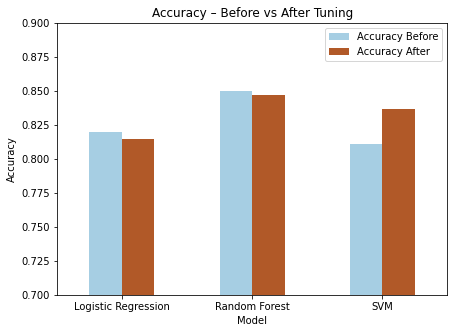

<Figure size 504x360 with 0 Axes>

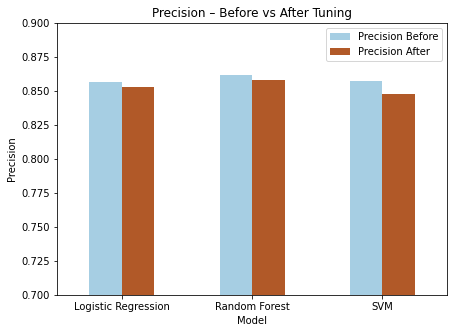

<Figure size 504x360 with 0 Axes>

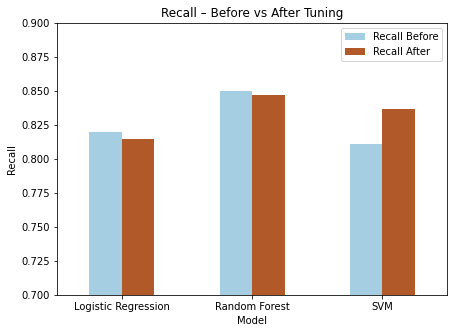

<Figure size 504x360 with 0 Axes>

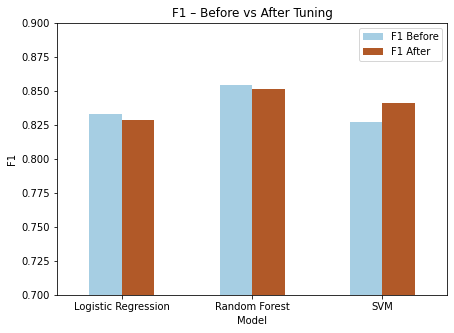

In [9]:
# -------------------------------
# Collect Before vs After Results (All Metrics)
# -------------------------------
comparison_all = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "SVM"],
    
    "Accuracy Before": [
        accuracy_score(y_test, y_pred_logreg),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_svm)
    ],
    "Accuracy After": [
        accuracy_score(y_test, y_pred_lr_tuned),
        accuracy_score(y_test, y_pred_rf_tuned),
        accuracy_score(y_test, y_pred_svm_tuned)
    ],
    
    "Precision Before": [
        precision_score(y_test, y_pred_logreg, average='weighted'),
        precision_score(y_test, y_pred_rf, average='weighted'),
        precision_score(y_test, y_pred_svm, average='weighted')
    ],
    "Precision After": [
        precision_score(y_test, y_pred_lr_tuned, average='weighted'),
        precision_score(y_test, y_pred_rf_tuned, average='weighted'),
        precision_score(y_test, y_pred_svm_tuned, average='weighted')
    ],
    
    "Recall Before": [
        recall_score(y_test, y_pred_logreg, average='weighted'),
        recall_score(y_test, y_pred_rf, average='weighted'),
        recall_score(y_test, y_pred_svm, average='weighted')
    ],
    "Recall After": [
        recall_score(y_test, y_pred_lr_tuned, average='weighted'),
        recall_score(y_test, y_pred_rf_tuned, average='weighted'),
        recall_score(y_test, y_pred_svm_tuned, average='weighted')
    ],
    
    "F1 Before": [
        f1_score(y_test, y_pred_logreg, average='weighted'),
        f1_score(y_test, y_pred_rf, average='weighted'),
        f1_score(y_test, y_pred_svm, average='weighted')
    ],
    "F1 After": [
        f1_score(y_test, y_pred_lr_tuned, average='weighted'),
        f1_score(y_test, y_pred_rf_tuned, average='weighted'),
        f1_score(y_test, y_pred_svm_tuned, average='weighted')
    ]
})

print("=== Before vs After Tuning (All Metrics) ===")
print(comparison_all)

# -------------------------------
# Bar Charts for Each Metric
# -------------------------------
metrics = ["Accuracy", "Precision", "Recall", "F1"]

for metric in metrics:
    plt.figure(figsize=(7,5))
    comparison_all.set_index("Model")[[f"{metric} Before", f"{metric} After"]].plot(
        kind="bar", figsize=(7,5), colormap="Paired"
    )
    plt.title(f"{metric} – Before vs After Tuning")
    plt.ylabel(metric)
    plt.ylim(0.7, 0.9)  # Adjust if needed
    plt.xticks(rotation=0)
    plt.show()


## 10. Future Work

- Incorporating more features (e.g., expected goals, physical tracking data) could improve prediction of Medium and High goal categories.  
- Trying other advanced models such as Gradient Boosting (XGBoost, LightGBM) may yield higher performance.  
- Applying feature selection or dimensionality reduction (PCA) might help reduce noise and improve generalization.  
- Testing on unseen seasons would make the model more realistic for forecasting future player performance.
- Although SMOTE was used to handle class imbalance, alternative strategies (e.g., class-weighted models, focal loss, or ensemble techniques) could also be explored. Models still tend to favor the Low class, indicating that richer features are needed to better separate Medium and High categories.
